In [ ]:
import torch
import math
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [ ]:
seq_length = 4
input_dim = 512
d_model = 512
batch_size = 1
x = torch.randn((batch_size,seq_length,input_dim))
x.shape

torch.Size([1, 4, 512])

In [ ]:
qkv_layer = nn.Linear(input_dim , 3 * d_model) # creates query , key , value vector all concatenated
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

Visualisation of qkv

Text(0.5, 1.0, 'qkv distribution')

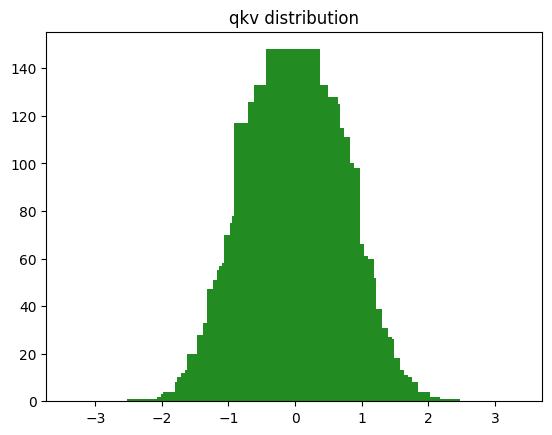

In [ ]:
import matplotlib.pyplot as plt

y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3

plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [ ]:
num_heads = 8
head_dim = d_model // num_heads

#reshaping according to number of heads
qkv = qkv.reshape(batch_size,seq_length,num_heads,3*head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [ ]:
qkv = qkv.permute(0,2,1,3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [ ]:
 q,k,v = qkv.chunk(3,dim=-1) # chunking is done w.r.t last dimension in qkv

In [ ]:
q.shape , k.shape ,v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

Self Attention for Multi heads

In [ ]:
d_k = q.size()[-1]
scaled = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k) # multiplication should be done with transpose since it is four dimesional
scaled.shape # end up seq_length * seq_length

torch.Size([1, 8, 4, 4])

In [ ]:
k.T.shape, torch.transpose(k,-1,-2).shape

(torch.Size([64, 4, 8, 1]), torch.Size([1, 8, 64, 4]))

Masking

In [ ]:
mask = torch.full(scaled.shape,float ('-inf'))
mask = torch.triu(mask,diagonal = 1)
mask[0][0] #for single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [ ]:
(scaled + mask)[0][0]

tensor([[-0.4779,    -inf,    -inf,    -inf],
        [-0.2299,  0.2166,    -inf,    -inf],
        [ 0.0732,  0.4807,  0.0734,    -inf],
        [ 0.5490,  0.4683,  0.5494,  0.4243]], grad_fn=<SelectBackward0>)

In [ ]:
scaled+=mask

In [ ]:
attention = F.softmax(scaled, dim=-1)
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3902, 0.6098, 0.0000, 0.0000],
        [0.2855, 0.4290, 0.2855, 0.0000],
        [0.2628, 0.2424, 0.2629, 0.2320]], grad_fn=<SelectBackward0>)

In [ ]:
#new values
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

To sum up..

In [ ]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [ ]:
values.size(), attention.shape

(torch.Size([1, 8, 4, 64]), torch.Size([1, 8, 4, 4]))

In [ ]:
#Concatenating all the heads
values = values.reshape(batch_size, seq_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [ ]:
linear_layer = nn.Linear(d_model, d_model)

In [ ]:
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

In [ ]:
out[0][0][0]

tensor(0.0651, grad_fn=<SelectBackward0>)

SUM UP....


In [ ]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out



In [ ]:

input_dim = 512
d_model = 512
num_heads = 8

batch_size = 3
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)


x.size(): torch.Size([3, 5, 512])
qkv.size(): torch.Size([3, 5, 1536])
qkv.size(): torch.Size([3, 5, 8, 192])
qkv.size(): torch.Size([3, 8, 5, 192])
q size: torch.Size([3, 8, 5, 64]), k size: torch.Size([3, 8, 5, 64]), v size: torch.Size([3, 8, 5, 64]), 
values.size(): torch.Size([3, 8, 5, 64]), attention.size:torch.Size([3, 8, 5, 5]) 
values.size(): torch.Size([3, 5, 512])
out.size(): torch.Size([3, 5, 512])
